In this notebook, we begin to work with the data that we scraped from arXiv and then preprocessed in `Scarping and Cleaning the Data.ipynb`. The goal is to predict the 3-character [MSC (Mathematical Subject Classification)](https://mathscinet.ams.org/mathscinet/msc/msc2020.html) classes for a preprint based on the feature `cleaned_text` obtained from preprocessing the title and abstract.<a name="cite_ref-a"></a>[<sup>*</sup>](#cite_note-a) This turns out to be a multi-label text classification task:

$\hspace{3cm}$  `cleaned_text` $\mapsto$ 3-character MSC classes (e.g. 46L, 57M, 57R) $\hspace{1cm}$  (~160,000 data points and ~500 labels).
    


More precisely, here, we will:
1) explore and visualize the data,
2) encode the labels,
3) split into the training and test sets via [stratified sampling for multi-label data](https://link.springer.com/chapter/10.1007/978-3-642-23808-6_10),
4) vectorize the text data with [TF-IDF (Term Frequency-Inverse Document Frequency)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf),
5) train a simple support vector machine classifier. 

Based on the classifier above, models for predicting coarser target variables such as the 2-character MSC classes (*simplified* labels) may be constructed: 

$\hspace{3cm}$  `cleaned_text` $\mapsto$ 3-character MSC classes (e.g. 46L, 57M, 57R) 
$\mapsto$ 2-character MSC classes (e.g. 46, 57) $\hspace{1cm}$  (~60 labels).



<a name="cite_note-a"></a>[*](#cite_ref-a) Our data has other attributes as well, such as the primary arXiv category, authors' names etc.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import json

import pickle as pkl
import gzip

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score, jaccard_score
from sklearn.calibration import CalibratedClassifierCV

#stratified.py is imported (from the same folder) for multi-label stratified sampling. 
#The short python code is based on the iterstrat library.
from stratified import multilabel_train_test_split

from scipy import sparse

We first load the data. Among the columns, we only keep `cleaned_text` and `MSC`.

In [2]:
raw_data=pd.read_csv('./data/data.zip',compression='zip')
raw_data=raw_data[['cleaned_text','MSC']]
print('Size of the raw data: ',raw_data.shape[0])

#While loading, the lists under the MSC column are loaded as strings. They should be turned back into lists.
raw_data['MSC']=raw_data['MSC'].apply(lambda x:eval(x))
raw_data.head()

Size of the raw data:  164230


,cleaned_text,MSC
0,massiv parallel eulerian lagrangian method adv...,"[65Y, 65M]"
1,algebra irreduc modul varieti iii birkhoff var...,"[16G, 14L]"
2,exist smooth orbit varieti simpl lie algebra o...,"[17B, 14M, 05E, 14L]"
3,polyhedr realize crystal base convex geometr d...,"[14M, 05E, 52B]"
4,high curv orbit space infimum section curvatur...,"[53B, 22E, 57S]"


The labels (MSC classes) should be encoded. This results in the data frame `data`. In parallel, we create `data_simpl` with simplified (2-character MSC classes) encoded labels. As we go over the data to encode the labels, we also form a dictionary of different words that constitute the text along with their multiplicities. 

In [3]:
#The lists of distinct labels and simplified labels that come up.
MSC_list=list(set.union(*raw_data['MSC'].apply(lambda x: set([y for y in x])).to_list()))
MSC_simpl_list=list(set.union(*raw_data['MSC'].apply(lambda x: set([y[:2] for y in x])).to_list()))

#Listing the numbers of labels and distinct lables across the data. 
num_labels=raw_data['MSC'].apply(lambda x: len(x)).to_list()
num_simpl_labels=raw_data['MSC'].apply(lambda x: len(set([y[:2] for y in x]))).to_list()

print(f'The number of distinct labels is {len(MSC_list)}.')
print(f"The average number of labels per entry is {round(sum(num_labels)/raw_data.shape[0],2)}.\n")

print(f'The number of distinct simplified labels is {len(MSC_simpl_list)}.')
print(f"The average number of simplified labels per entry is {round(sum(num_simpl_labels)/raw_data.shape[0],2)}.\n")


#We initialize a dictionary to record the multiplicities of various words that appear in the text data. 
#We go over the data frame to update the dictionary, and to encode the labels. 
dict_words={} 

#Adding columns for encoded labels. 
data=pd.concat((raw_data,pd.DataFrame(data=0,index=np.arange(raw_data.shape[0]),
                             columns=MSC_list)),axis=1)
data_simpl=pd.concat((raw_data,pd.DataFrame(data=0,index=np.arange(raw_data.shape[0]),
                             columns=MSC_simpl_list)),axis=1)


for row in range(data.shape[0]):
    
    words=data['cleaned_text'][row].split(' ')      #The text has been cleaned already, no consecutive spaces.
    for word in words: 
        if word in dict_words.keys():
            dict_words[word]+=1
        else:
            dict_words[word]=1
                
    classes=data['MSC'][row]
    for MSC in classes:
        data.at[row,MSC]=1
    
    simpl_classes=list(set([x[:2] for x in classes]))
    for MSC in simpl_classes:
        data_simpl.at[row,MSC]=1
        

data.drop(columns=['MSC'],inplace=True)
data_simpl.drop(columns=['MSC'],inplace=True)


dict_MSC={}
for MSC in MSC_list:
    dict_MSC[MSC]=data[MSC].sum()

    
dict_MSC_simpl={}
for MSC in MSC_simpl_list:
    dict_MSC_simpl[MSC]=data_simpl[MSC].sum()

    
data.head()

The number of distinct labels is 532.
The average number of labels per entry is 2.35.

The number of distinct simplified labels is 63.
The average number of simplified labels per entry is 1.87.



,cleaned_text,93C,34N,51P,18B,76T,65Z,13G,26B,34M,...,60H,45P,51H,47J,53B,06E,51M,14B,03H,51K
0,massiv parallel eulerian lagrangian method adv...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,algebra irreduc modul varieti iii birkhoff var...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,exist smooth orbit varieti simpl lie algebra o...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,polyhedr realize crystal base convex geometr d...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,high curv orbit space infimum section curvatur...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Visualizing the most common labels (MSC classes). 

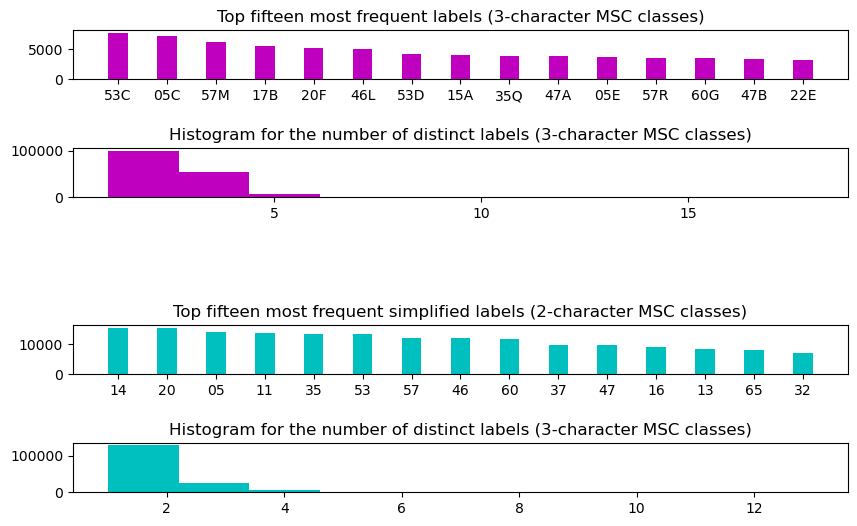

In [4]:
fig=plt.figure(figsize=(10,6))


#Top 10 most frequent MSC classes (bar chart)
ax1=fig.add_subplot(8,1,1)
top_index=np.argsort(-np.asarray(list(dict_MSC.values())))[0:15]
ax1.bar(x=np.asarray(list(dict_MSC.keys()))[top_index],
        height=np.asarray(list(dict_MSC.values()))[top_index],width=0.4,color='m')
ax1.set_title('Top fifteen most frequent labels (3-character MSC classes)')

#Number of labels (histogram)
ax2=fig.add_subplot(8,1,3)
ax2.hist(num_labels,color='m')
ax2.locator_params(axis='x', integer=True)
ax2.set_title('Histogram for the number of distinct labels (3-character MSC classes)')


#Top 10 most frequent 2-character MSC classes (bar chart)
ax3=fig.add_subplot(8,1,6)
top_index=np.argsort(-np.asarray(list(dict_MSC_simpl.values())))[0:15]
ax3.bar(x=np.asarray(list(dict_MSC_simpl.keys()))[top_index],
        height=np.asarray(list(dict_MSC_simpl.values()))[top_index],width=0.4,color='c')
ax3.set_title('Top fifteen most frequent simplified labels (2-character MSC classes)')


#Number of simplified labels (histogram)
ax2=fig.add_subplot(8,1,8)
ax2.hist(num_simpl_labels,color='c')
ax2.locator_params(axis='x', integer=True)
ax2.set_title('Histogram for the number of distinct labels (3-character MSC classes)')



plt.show()

If a label occurs only once throughout the data, then either the training or the test dataset will lack it. To avoid this, we drop all such labels along with instances whose only label is such a thing (if any).

In [5]:
MSC_only_once=[]
ascending=np.argsort(np.asarray(list(dict_MSC.values())))
for arg in ascending:
    if np.asarray(list(dict_MSC.values()))[arg]==1:
        MSC_only_once+=[np.asarray(list(dict_MSC.keys()))[arg]]
    else:
        break

print('MSC classes that happen only once are:', *MSC_only_once)

#Deleting these keys from the corresponding dictionary and list
for MSC in MSC_only_once:
    del dict_MSC[MSC]
    MSC_list.remove(MSC)

data.drop(columns=MSC_only_once,inplace=True)

if data[(data.iloc[:,1:]==0).all(axis=1)].shape[0]==0:
    print('\nNo need to drop any rows.')
else: 
    drop_index=data[(data.iloc[:,1:]==0).all(axis=1)].index
    data.drop(columns=MSC_only_once,inplace=True)
    print(f'\nThe number of rows dropped is {drop_index.shape[0]}')


#Saving the encoded data in a compressed form.     
data.to_csv('./data/data_encoded.zip',compression='zip',index=False)

MSC classes that happen only once are: 83B

No need to drop any rows.


We next look at the `cleaned_text` column (to be used as the input text data). How many words appear there? Which words have been most common?

The total number of words appearing in the cleaned text data is 86957.

The average number of words per cleaned text is 57.29.


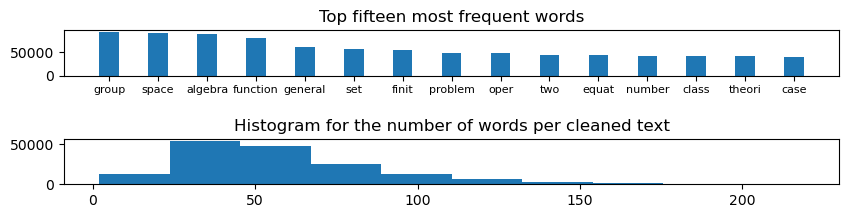

In [6]:
print(f'The total number of words appearing in the cleaned text data is {len(dict_words)}.\n')

num_words=data['cleaned_text'].apply(lambda x:len(x.split(' ')))

print(f'The average number of words per cleaned text is {round(num_words.mean(),2)}.')

fig=plt.figure(figsize=(10,2))
ax1=fig.add_subplot(3,1,1)

#Top 15 most frequent primary categories (bar chart)
top_index=np.argsort(-np.asarray(list(dict_words.values())))[0:15]
ax1.bar(x=np.asarray(list(dict_words.keys()))[top_index],
        height=np.asarray(list(dict_words.values()))[top_index],width=0.4)
ax1.set_title('Top fifteen most frequent words')
plt.xticks(fontsize=8)

ax2=fig.add_subplot(3,1,3)

#Number of constituent words (histogram)
ax2.hist(num_words)
ax2.locator_params(axis='x', integer=True)
ax2.set_title('Histogram for the number of words per cleaned text')

plt.show()

Stratified splitting of the data into training and test sets based on the [iterative-stratification](https://github.com/trent-b/iterative-stratification) library. We save the corresponding row indices for future use. We also keep a small validation set which will later be used for probability calibration. 

In [7]:
X_temp, X_test, y_temp, y_test = multilabel_train_test_split(data['cleaned_text'],
                                                               data.iloc[:,1:],stratify=data.iloc[:,1:], 
                                                               test_size=0.25, random_state=2)

X_train, X_val, y_train, y_val = multilabel_train_test_split(X_temp,
                                                               y_temp,stratify=y_temp, 
                                                               test_size=0.15, random_state=1)


train_index=np.asarray(X_train.index).tolist()
print(f'The number of training instances: {len(train_index)}')
with open('./data/train_index.json','w') as file:
    json.dump(train_index,file)
    
val_index=np.asarray(X_val.index).tolist()
print(f'The number of validation instances: {len(val_index)}')
with open('./data/val_index.json','w') as file:
    json.dump(val_index,file)

test_index=np.asarray(X_test.index).tolist()
print(f'The number of test instances: {len(test_index)}')
with open('./data/test_index.json','w') as file:
    json.dump(test_index,file)

The number of training instances: 104675
The number of validation instances: 18540
The number of test instances: 41015


Making sure no label is all zero in either the training or the test set. 

In [8]:
print(f'The number of all-zero columns in y_train is {np.sum((np.sum(y_train,axis=0)==0).astype(int))}.\n')

print(f'The number of all-zero columns in y_test is {np.sum((np.sum(y_test,axis=0)==0).astype(int))}.')

The number of all-zero columns in y_train is 0.

The number of all-zero columns in y_test is 0.


Are different labels (MSC classes) distributed evenly between the training and test sets? Bar charts for the relative frequency of top MSC classes would tell.

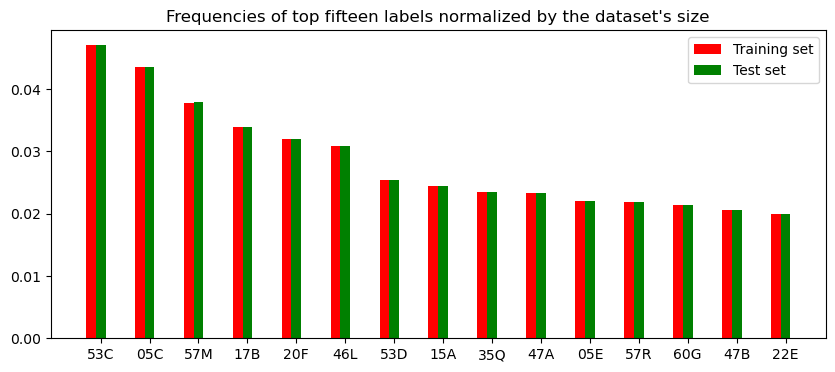

In [9]:
top_index=np.argsort(-np.asarray(list(dict_MSC.values())))[0:15]
top_MSC=np.asarray(list(dict_MSC.keys()))[top_index]


ind=np.arange(15)
width=0.2

fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(111)
ax.bar(x=ind, height=y_train[top_MSC].sum(axis=0)/y_train.shape[0], width=width, color='r')
ax.bar(x=ind+width, height=y_test[top_MSC].sum(axis=0)/y_test.shape[0], width=width, color='g')
ax.set_xticks(ind+width)
ax.set_xticklabels(top_MSC)

ax.set_title("Frequencies of top fifteen labels normalized by the dataset's size")
ax.legend(('Training set','Test set'))

plt.show()

Next, we proceed with training a model for predicting MSC classes based on the text data under the column `cleaned_title`. First, the text data should be vectorized. 

In [10]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=50000)
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

print(f'The shapes of X_train and X_test (after encoding): {X_train.shape} and  {X_test.shape}\n')
print(f'The shapes of y_train and y_test: {y_train.shape} and  {y_test.shape}')

The shapes of X_train and X_test (after encoding): (104675, 50000) and  (41015, 50000)

The shapes of y_train and y_test: (104675, 531) and  (41015, 531)


Let's use SVM classifier with linear kernel. To build a model, we utilize scikit-learn's `OnevsRest` classifiers—which [supports](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) multilabel classification—based on `LinearSVC`. `LinearSVC` is [much faster](https://stackoverflow.com/questions/35076586/when-should-one-use-linearsvc-or-svc) than `SVC` with linear kernel. For the base `LinearSVC` classifier, we set `class_weight='balanced'` since the classes are imbalanced, and we tune its hyperparameter `C` via cross-validation on the training set. The hyperparameter `C` [controls](https://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel) the hyperplane's margin (larger `C` means larger cost for misclassification on the training set, and results in hyperplanes with smaller margins). 

In [11]:
for C in [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]:
    clf= OneVsRestClassifier(LinearSVC(penalty='l2',loss='squared_hinge',random_state=123,C=C,class_weight='balanced'),
                             n_jobs=-1)
    scores=cross_val_score(clf,X_train,y_train,cv=3,n_jobs=-1,scoring='f1_weighted')
    print(f'C={C}, the average cross-validation score={np.mean(scores)}')    

C=0.1, the average cross-validation score=0.43431103399313314
C=0.5, the average cross-validation score=0.47976967268271764
C=1, the average cross-validation score=0.47667680919368854
C=5, the average cross-validation score=0.4445301760007694
C=10, the average cross-validation score=0.43309325560814943
C=50, the average cross-validation score=0.4199074414785003
C=100, the average cross-validation score=0.41763555010764913
C=500, the average cross-validation score=0.4155933485374495
C=1000, the average cross-validation score=0.41536124804528773


The cross-validation score reaches its maximum when `C=0.5`. So we choose this value for the hyperparameter, and we fit over the whole training set. We shall then evaluate various scikit-learn metrics including the variants of the `f1_score` and the `accuracy_score`. The latter only takes into account data instances for which all predicted labels match the true ones. On the other hand, the metrics `hamming_loss` and `jaccard_score` also reward cases where the predicted labels agree only partially. But for our data, `hamming_loss` would not be very illuminating since most labels are zero (i.e. high number of true negatives). Instead, we use the `jaccard_score` to capture the similarity of the predicted labels and the true labels for a data point (which returns the ratio of true positives to the number of labels that are positive or are predicted to be positive, or both.)

In [12]:
clf=OneVsRestClassifier(LinearSVC(random_state=123,C=0.5,class_weight='balanced'),n_jobs=-1)

clf.fit(X_train, y_train)


y_pred_train=clf.predict(X_train)
y_pred=clf.predict(X_test)


print('Metrics for predicting 3-character MSC classes based on the cleaned text:\n')
print(f' Train Accuracy: {round(100*accuracy_score(y_train, y_pred_train, normalize=True),2)}%')
print(f" Train F1-score micro: {round(100*f1_score(y_train, y_pred_train, average='micro'),2)}%")
print(f" Train F1-score macro: {round(100*f1_score(y_train, y_pred_train, average='macro'),2)}%")
print(f" Train F1-score weighted: {round(100*f1_score(y_train, y_pred_train, average='weighted'),2)}%")
print(f" Train average Jaccard score: {round(100*jaccard_score(y_train, y_pred_train, average='samples'),2)}%")



print(f' \n Test Accuracy:  {round(100*accuracy_score(y_test, y_pred, normalize=True),2)}%')
print(f" Test F1-score micro: {round(100*f1_score(y_test, y_pred, average='micro'),2)}%")
print(f" Test F1-score macro: {round(100*f1_score(y_test, y_pred, average='macro'),2)}%")
print(f" Test F1-score weighted: {round(100*f1_score(y_test, y_pred, average='weighted'),2)}%") 
print(f" Test average Jaccard score: {round(100*jaccard_score(y_test, y_pred, average='samples'),2)}%") 

Metrics for predicting 3-character MSC classes based on the cleaned text:

 Train Accuracy: 38.63%
 Train F1-score micro: 81.48%
 Train F1-score macro: 87.63%
 Train F1-score weighted: 81.84%
 Train average Jaccard score: 73.05%
 
 Test Accuracy:  9.4%
 Test F1-score micro: 50.53%
 Test F1-score macro: 38.25%
 Test F1-score weighted: 50.18%
 Test average Jaccard score: 39.03%


The accuracy scores may seem to be poor, but keep in mind that there are more than 500 labels. The Jaccard scores are better as expected since they reward predictions that match the true labels partially as well. Moreover, we observe that, over the test set, the $F_1$ score is much better under `average='weighted'` than `average='macro'`. Thus, we expect higher $F_1$ scores for labels that come up more often. The cell below verifies this. 

In [13]:
list_top_f1=[]
for top_class in top_MSC:
    column_index=MSC_list.index(top_class)
    list_top_f1+=[round(100*f1_score(y_test[top_class],y_pred[:,column_index]),2)]
    
print(f'Test F1-scores for the top fifteen most frequent labels:\n {list_top_f1}')

Test F1-scores for the top fifteen most frequent labels:
 [64.45, 70.57, 64.13, 66.65, 62.88, 72.47, 65.43, 51.46, 54.29, 51.89, 48.57, 48.65, 53.6, 51.03, 51.93]


How has the classifier performed if we restrict to test instances with a fixed number of labels?

In [14]:
y_1=np.asarray(y_test)
y_2=y_pred

n_labels=1
list_n_labels=[]
list_accuracy=[]
list_jaccard=[]
list_f1=[]

while True:
    index_indicator=np.where(y_1.sum(axis=1)==n_labels)[0]
    if index_indicator.shape[0]==0:
        break
    list_n_labels+=[n_labels]
    
    list_accuracy+=[round(100*accuracy_score(y_1[index_indicator],y_2[index_indicator]),2)]
    
    #The zero_division=np.nan option: Among the rows of y_test that we have separated, some columns may be all 0. 
    list_f1+=[round(100*f1_score(y_1[index_indicator],y_2[index_indicator],average='weighted',zero_division=np.nan),2)]
    
    list_jaccard+=[round(100*jaccard_score(y_1[index_indicator],y_2[index_indicator],average='samples',zero_division=0),2)]
    
    #The average number of incorrectly predicted labels
    n_labels+=1
    
print(f'Accuracy socres over the test data as the number of labels increases:\n {list_accuracy}\n\n')
print(f'Weighted F1-scores over the test data as the number of labels increases:\n {list_f1}\n\n')
print(f'Average Jaccard scores over the test data as the number of labels increases:\n {list_jaccard}')

Accuracy socres over the test data as the number of labels increases:
 [16.77, 9.42, 4.81, 3.01, 1.41, 1.19, 2.89, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Weighted F1-scores over the test data as the number of labels increases:
 [48.91, 53.08, 52.67, 52.54, 51.91, 51.96, 56.6, 57.96, 77.63, 71.39, 91.63, 85.71, 100.0, 94.44, 100.0, 75.64]


Average Jaccard scores over the test data as the number of labels increases:
 [38.32, 40.8, 39.16, 37.89, 35.78, 33.39, 31.95, 29.25, 31.01, 25.6, 37.75, 31.38, 28.57, 17.75, 15.88, 43.89]


We observe that the accuracy score (which detects only rows of `y_test` and `y_pred` that match exactly) becomes poorer with more labels. One the other hand, the weighted $F_1$ and Jaccard scores are much more reasonable. 

For each of the fifteen most prevalent labels (MSC classes) recorded previously, in the cell below, we print the most contributing text tokens by detecting the coefficients with the largest absolute values in the binary `LinearSVC` classifier corresponding to that label. Moreover, the description of that class is read and printed from an appropriate file. 

In [15]:
df=pd.read_csv('./data/MSCclasses.csv',index_col=False)
tokens=vectorizer.get_feature_names_out()
print('Top three most important text tokens for the most frequent labels:\n\n')
for top_class in top_MSC:
    description=df[df['class']==top_class]['description'].to_string(index=False)
    column_index=MSC_list.index(top_class)
    coef_sorted_index=np.argsort(-np.abs(clf.estimators_[column_index].coef_))
    top_token_1=tokens[coef_sorted_index[0][0]]
    top_token_2=tokens[coef_sorted_index[0][1]]
    top_token_3=tokens[coef_sorted_index[0][2]]
    print(f' {top_class}: {description}     Most important tokens:  {top_token_1}, {top_token_2}, {top_token_3}\n')

Top three most important text tokens for the most frequent labels:


 53C:  Global dierential geometry     Most important tokens:  symmetr space, carnot, hyperkahl

 05C:  Graph theory     Most important tokens:  graph, tree, digraph

 57M:  General low-dimensional topology     Most important tokens:  knot, link, quandl

 17B:  Lie algebras and Lie superalgebras     Most important tokens:  lie, vertex oper, lie algebra

 20F:  Special aspects of innite or nite groups     Most important tokens:  group, coxet, hyperbol group

 46L:  Selfadjoint operator algebras ( C-algebras, v...     Most important tokens:  hilbert modul, subfactor, noncommut

 53D:  Symplectic geometry, contact geometry     Most important tokens:  symplect, moment map, lagrangian

 15A:  Basic linear algebra     Most important tokens:  matric, matrix, vector space

 35Q:  Partial dierential equations of mathematical ...     Most important tokens:  nls, riemann hilbert, maxwel

 47A:  General theory of linear opera

Observe that the printed tokens are often mathematically meaningful terms, and moreover relevant to the topic in hand. 

`LinearSVC` [does not output probabilities](https://stackoverflow.com/questions/26478000/converting-linearsvcs-decision-function-to-probabilities-scikit-learn-python). What if one needs probabilities for each MSC class? The probabilities may be used to generate an output especially when all predicted binary labels are zero (i.e. when the model associates no MSC class with the input). One option is  [probability calibration](https://scikit-learn.org/stable/modules/calibration.html) via scikit-learn's `CalibratedClassifierCV`. Since `clf` is a `OnevsRest` classifier trained for a multi-label problem, we calibrate the binary classifier corresponding to each label instead of calibrating `clf` itself. The validation set will be used for calibrating probability scores. As the binary classifiers are already fitted, we use the `cv=prefit` option in `CalibratedClassifierCV` (see [here](https://stats.stackexchange.com/questions/263393/scikit-correct-way-to-calibrate-classifiers-with-calibratedclassifiercv)).

In [16]:
list_calibrated_estimators=[]
for i in range(y_val.shape[1]):
    calibrated_estimator=CalibratedClassifierCV(clf.estimators_[i],cv='prefit').fit(X_val,y_val.iloc[:,i])
    list_calibrated_estimators+=[calibrated_estimator]
    
class ConcatModels:
    '''
    Concatenate provided binary classifiers which have a predict_proba method.
    '''
    def __init__(self,list_models):
        self.models=list_models
        
    def predict_proba(self,X):
        return np.transpose(np.asarray([model.predict_proba(X)[:,1] for model in self.models]))

clf_calibrated=ConcatModels(list_calibrated_estimators)

Are the probabilities from `clf_calibrated` in accord with the labels predicted by `clf`?

In [17]:
y_pred_proba=clf_calibrated.predict_proba(X_test)
pred_proba_arg_sorted=np.argsort(-y_pred_proba,axis=1) #Sorting the predicted probabilities in descending order.
n_random_instance=10
random_indices=random.sample(list(np.arange(X_test.shape[0])),k=n_random_instance)
n_top=5

print(f'Comparing labels predicted by the classifier with top {n_top} labels with highest probability according to the calibrated classifier for {n_random_instance} test data points:\n')
for random_index in random_indices:
    print(f'Predicted labels by column index: {list(np.where(y_pred[random_index]==1)[0])}, Top most probable labels by column index: {list(pred_proba_arg_sorted[random_index][:5])}')
    

Comparing labels predicted by the classifier with top 5 labels with highest probability according to the calibrated classifier for 10 test data points:

Predicted labels by column index: [54, 99, 334], Top most probable labels by column index: [334, 99, 54, 268, 199]
Predicted labels by column index: [210, 239, 278, 433, 446, 513], Top most probable labels by column index: [446, 278, 239, 513, 433]
Predicted labels by column index: [289, 353], Top most probable labels by column index: [289, 353, 139, 47, 465]
Predicted labels by column index: [229, 435], Top most probable labels by column index: [229, 435, 464, 112, 138]
Predicted labels by column index: [13, 23, 48, 129, 228, 231], Top most probable labels by column index: [23, 228, 129, 231, 13]
Predicted labels by column index: [136, 449, 480], Top most probable labels by column index: [136, 480, 449, 524, 371]
Predicted labels by column index: [268, 305], Top most probable labels by column index: [268, 305, 185, 462, 266]
Predicted

Finally, based on `clf`, we construct another classfier `clf_simplified` for predicting simplified labels.

In [18]:
#A binary matrix that captures the relation between 3-character and 2-character (truncated) MSC classes.
T=np.zeros([len(MSC_list),len(MSC_simpl_list)])

for i in range(len(MSC_list)):
    for j in range(len(MSC_simpl_list)):
        if MSC_list[i][:2]==MSC_simpl_list[j]:
            T[i][j]=1
            
class clf_reduction:
    '''
    Composing with a linear transformation to obtain outputs in passing from a space of one-hot encoded 
    features to a smaller such space.
    The probabilities for the new labels may be outputted as well if the original classifier has a predict_proba method, 
    or, alternatively, if a calibrated classifier is provided. 
    (In the multi-label setting, those probabilities should be interpreted as lower bounds).  
    '''
    def __init__(self, clf, T, clf_calibrated=None):
        self.clf=clf
        self.transformation=T
        if clf_calibrated==None:
            self.clf_calibrated=clf
        else:
            self.clf_calibrated=clf_calibrated
            
    def predict(self,X):
        return (np.matmul(self.clf.predict(X),T)>0).astype(int) 
    
    
    def predict_proba(self,X,multi_label=True):
        if multi_label:               #See https://stackoverflow.com/questions/41164305/numpy-dot-product-with-max-instead-of-sum
            return np.max(self.clf_calibrated.predict_proba(X)[:, :, None] * T[None, :, :], axis = 1)
        else:                         #The classification task is multi-class, not multi-label.
            return np.matmul(self.clf_calibrated.predict_proba(X),T)
    
    
clf_simplified=clf_reduction(clf,T,clf_calibrated)
y_pred_simplified=clf_simplified.predict(X_test)

print('Metrics for predicting 2-character MSC classes based on the cleaned text:\n')
print(f' Test Accuracy:  {round(100*accuracy_score(data_simpl.iloc[test_index,1:], y_pred_simplified, normalize=True),2)}%')
print(f" Test F1-score micro: {round(100*f1_score(data_simpl.iloc[test_index,1:], y_pred_simplified, average='micro'),2)}%")
print(f" Test F1-score macro: {round(100*f1_score(data_simpl.iloc[test_index,1:], y_pred_simplified, average='macro'),2)}%")
print(f" Test F1-score weighted: {round(100*f1_score(data_simpl.iloc[test_index,1:], y_pred_simplified, average='weighted'),2)}%") 
print(f" Test average Jaccard score: {round(100*jaccard_score(data_simpl.iloc[test_index,1:], y_pred_simplified, average='samples'),2)}%") 

Metrics for predicting 2-character MSC classes based on the cleaned text:

 Test Accuracy:  27.69%
 Test F1-score micro: 65.09%
 Test F1-score macro: 56.8%
 Test F1-score weighted: 65.02%
 Test average Jaccard score: 56.32%


Saving the trained models along with the names of their variables:

In [19]:
#We first pickle the trained models and then zip them. 
#https://stackoverflow.com/questions/18474791/decreasing-the-size-of-cpickle-objects
def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, 'wb') as f:
        pkl.dump(obj, f, protocol)

save_zipped_pickle(vectorizer,'./models/vectorizer.gz')
save_zipped_pickle(clf,'./models/clf_MSC.gz')
save_zipped_pickle(clf_calibrated,'./models/clf_MSC_calibrated.gz')
save_zipped_pickle(clf_simplified,'./models/clf_MSC_simplified.gz')

#Saving variable names
with open('./models/MSC_list.json','w') as file:
    json.dump(MSC_list,file)
with open('./models/MSC_list_simplified.json','w') as file:
    json.dump(MSC_simpl_list,file)    